# Summary of Results

## Load Model Training Results

In [2]:
import pandas as pd
import numpy as np

# load the classifier results
classifier_results = pd.read_json('data/classifiers_perf_result.json')
classifier_results

,classifier,best_params,train_time,accuracy_train,accuracy_test,conf_matrix,y_preds,y_pred_prob
0,MultinomialNB,{'alpha': 6.5654566984},8.258320,0.473898,0.473390,"[[0.5072463768000001, 0.0, 0.00671556980000000...","[2, 3, 2, 5, 3, 5, 5, 5, 5, 2, 2, 3, 2, 5, 5, ...","[[0.0026679183, 3.29242e-05, 0.5692127311, 0.0..."
1,RandomForestClassifier,"{'max_depth': 9, 'min_samples_leaf': 4, 'min_s...",2280.117239,0.622321,0.541946,"[[1.0, 0.0, 0.0020254304, 0.0998548621, 0.0, 0...","[2, 3, 2, 5, 5, 2, 2, 5, 3, 2, 2, 3, 2, 5, 2, ...","[[0.0056297561, 0.0010573604, 0.4990672821, 0...."
2,XGBClassifier,"{'gamma': 8.6138743525, 'learning_rate': 0.342...",30.488232,0.554972,0.526356,"[[0.5517241379, 0.0, 0.0024729157000000002, 0....","[2, 3, 2, 5, 5, 2, 2, 5, 3, 2, 2, 3, 3, 5, 2, ...","[[0.10710389170000001, 0.10598885270000001, 0...."


In [3]:
# load the neural net classifiers
nn_results = pd.read_json('data/nn_perf_result.json')
nn_results

,train time,accuracy_train,accuracy_test,conf_matrix,y_preds,y_pred_prob
0,5.245273,0.525340,0.521328,"[[0.8125, 0.07708553330000001, 0.0061840121000...","[very good, very good, very good, very good, v...","[[0.007839282000000001, 0.0005242912, 0.158221..."
1,45.141367,0.620138,0.612584,"[[0.6208053691000001, 0.042182325300000004, 0....","[good, very good, excellent, excellent, good, ...","[[0.0007170093, 0.0, 0.0675901249, 0.495748609..."
2,20.419924,0.607176,0.603088,"[[0.5896551724, 0.0724200362, 0.0027150304, 0....","[very good, very good, excellent, excellent, v...","[[0.0010636463, 4e-10, 0.0438137501, 0.3372171..."


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# the target classes
ratings = ['acceptable', 'good', 'very good', 'excellent', 'superb', 'classic']

def plot_confusion_matrix(conf_matrix, title):
  fig = plt.figure(figsize=(6, 3))
  ax = sns.heatmap(conf_matrix, xticklabels=ratings, yticklabels=ratings, annot=True, cmap="Purples", fmt=",.2f", annot_kws={"size": 8}, )
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=9, rotation=45)
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
  ax.set_ylabel('True Labels', fontdict={'size': 10})
  ax.set_xlabel('Predictions', fontdict={'size': 10})
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=9)
  plt.title(title)
  plt.tight_layout()
  plt.show()

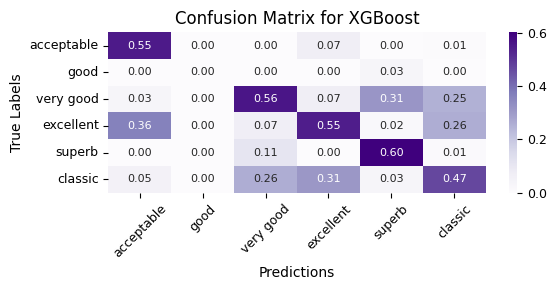

In [5]:
plot_confusion_matrix(classifier_results.loc[2, 'conf_matrix'], 'Confusion Matrix for XGBoost')

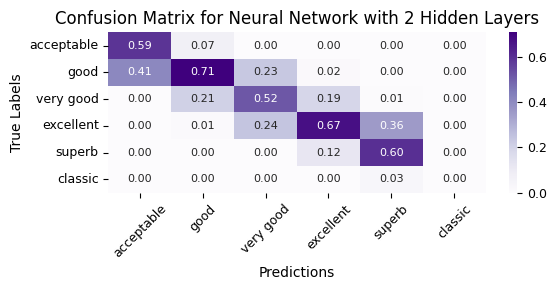

In [6]:
plot_confusion_matrix(nn_results.loc[2, 'conf_matrix'], 'Confusion Matrix for Neural Network with 2 Hidden Layers')

In [7]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


def plot_roc_curve(y_test, y_pred):
  classes = np.unique(y_test)
  n_classes = len(classes)
  y_test = label_binarize(y_test, classes=classes)
  y_pred = label_binarize(y_pred, classes=classes)

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  thresholds = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=(6,6))
  plt.plot(fpr["micro"], tpr["micro"],
           label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
           color="deeppink", linestyle=":", linewidth=4,)

  plt.plot(fpr["macro"], tpr["macro"],
           label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
           color="navy", linestyle=":", linewidth=4,)

  lw = 1
  colors = cycle(['aqua', 'darkorange', 'darkgreen', 'yellow', 'blue', 'mediumpurple'])
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class "{classes[i]}" (area = {roc_auc[i]:0.2f})',)

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC curve for Neural Net Classifier with 2 Hidden Layers")
  plt.legend()
  plt.tight_layout()
  plt.show()


In [8]:
# load true values
y_test = pd.read_json('data/nn_y_test.json')
y_test.y_test.to_list()[:5]

['good', 'very good', 'very good', 'excellent', 'good']

In [9]:
y_preds = nn_results.iloc[2].y_preds
y_preds[:5]

['very good', 'very good', 'excellent', 'excellent', 'very good']

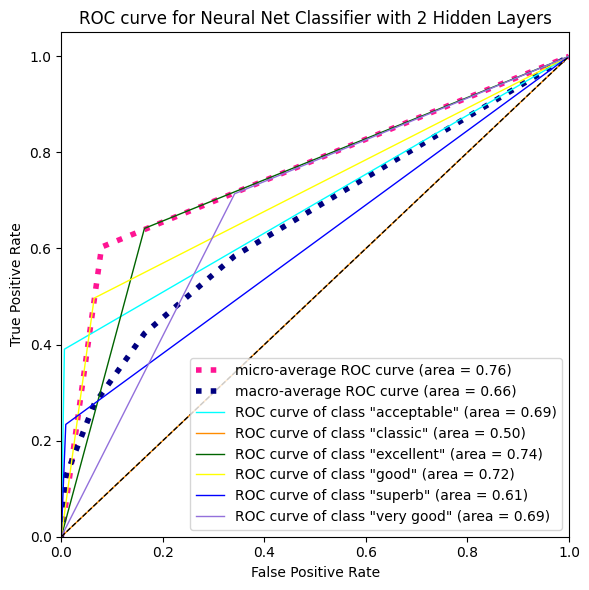

In [10]:
plot_roc_curve(y_test.y_test.to_list(), y_preds)

## Conclusion

Based on the confusion matrix, the neural classifier appears to have done a better job of predicting the rating based on the review than the XGBoost classifier. Not only did it achieve an accuracy of just over $60\%$, but the mislabels mostly were along the diagonal, indicating it was in the right direction. In contrast, XGBoost misclassified reviews far off the diagonal, indicating it was confusing reviews for wines that were rated very differently.

We can also conclude from the ROC curve that there is too little data for the highest class of wines, 'classic'.
